In [4]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

optimizers = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']
learning_rates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [29]:
def run_experiment(hidden_layer_units, x, optimizer='rmsprop'):

    # SETUP
    model = Sequential([
        Dense(name = "hidden_layer", units = hidden_layer_units, activation = tf.nn.relu, input_shape = (x.shape[1],)),
        Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
    ])
    model.summary()
    
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,           
                   loss = 'categorical_crossentropy',
                   metrics=['accuracy'])
    keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)
    
    
    # TRAIN
    history = model.fit(
        x,
        y_train_encoded,
        epochs = 10,
        validation_split=0.20 
        )

    # TEST
    # loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
    # print('test set accuracy: ', accuracy * 100)

    # PERFORMANCE
    history_dict = history.history
    history_dict.keys()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # ACCURACY
    plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
    plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
    plt.ylim([0.0, 1.0])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # LOSS
    plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
    plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
    plt.ylim([0.0, max(loss)])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # CONFUSION
    pred_classes = np.argmax(model.predict(x), axis=-1)
    pred_classes
    conf_mx = tf.math.confusion_matrix(y_train, pred_classes)
    conf_mx

    def plot_confusion_matrix(matrix):
        """If you prefer color and a colorbar"""
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        cax = ax.matshow(matrix)
        fig.colorbar(cax)

    print("Confusion Matrix")
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    plt.show()

def boxplot():
    ## PCA Feature Reduction
    #Get the dataframe of all the pixel values
    pixel_data = {'pred_class':pred_classes}
    for k in range(0,784): 
        pixel_data[f"pix_val_{k}"] = x[:,k]
    pixel_df = pd.DataFrame(pixel_data)
    pixel_df.head()

    # from sklearn.decomposition import PCA

    # Separating out the features
    features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
    x = pixel_df.loc[:, features].values 

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
    # Extracts the outputs of the 2 layers:
    layer_outputs = [layer.output for layer in model.layers]

    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    print(f"There are {len(layer_outputs)} layers:")
    for i in layer_outputs: print(i) # description of the layers


    # Get the outputs of all the hidden nodes for each of the 60000 training images
    activations = activation_model.predict(x)
    hidden_layer_activation = activations[0]
    output_layer_activations = activations[1]
    print()
    print('Outputs of hidden nodes:')
    print('Hidden layer shape:')
    print(hidden_layer_activation.shape)   #  each of the 128 hidden nodes has one activation value per training image
    print()
    print('Output layer shape:')
    print(output_layer_activations.shape)
    print()
    print(f"The maximum activation value of the hidden nodes in the hidden layer: \
    {hidden_layer_activation.max()}")

    #Get the dataframe of all the node values
    activation_data = {'pred_class':pred_classes}
    for k in range(0,hidden_layer_units): 
        activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]
    

    activation_df = pd.DataFrame(activation_data)
    # To see how closely the hidden node activation values correlate with the class predictions
    # Let us use seaborn for the boxplots this time.
    bplot = sns.boxplot(y='act_val_0', x='pred_class', 
                     data=activation_df[['act_val_0','pred_class']], 
                     width=0.5,
                     palette="colorblind")
    return pixel_df

# Prepocessing

In [8]:
print("Load MNIST data set:")
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

print()
print("Encode y data:") 
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))
print()
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)


print()
print('Min-Max Normalization:')
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
print(set(x_train_norm[0]))

Load MNIST data set:
x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)

Encode y data:
First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)
x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)

Min-Max Normalization:
{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.4

# EXPERIMENT 1: 
Our dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1)                 785       
_________________________________________________________________
output_layer (Dense)         (None, 10)                20        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 1s 958us/step - loss: 2.0134 - accuracy: 0.2083 - val_loss: 1.8753 - val_accuracy: 0.2378
Epoch 2/10
1500/1500 [==============================] - 1s 888us/step - loss: 1.8298 - accuracy: 0.2523 - val_loss: 1.7851 - val_accuracy: 0.2701
Epoch 3/10
1500/1500 [==============================] - 1s 880us/step - loss: 1.7684 - accuracy: 0.2766 - val_loss: 1.7357 - val_accuracy: 0.2887
Epoch 4/10
1500/1500 [==============================] - 1s 924us/step - loss: 1.73

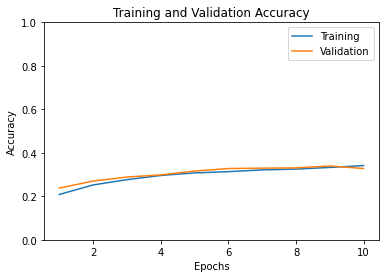

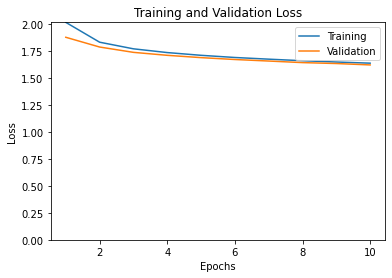

Confusion Matrix


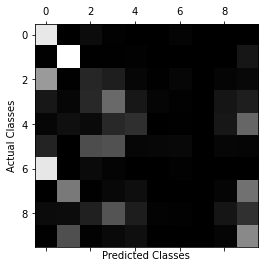

In [9]:
run_experiment(hidden_layer_units=1, x=x_train_norm)

# Results:
In experiment #1 a dense neural network consisting of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits in the MNIST data set) was trained. A maximum accuracy of 0.3571 was achieved after 10 epochs and considerable variability in predicted vs actual class was clearly visualized in a confusion matrix plot. Activation values of the hidden node for the (original) set of training images by the 10 predicted classes were extracted and visualized using a boxplot. As expected, minimal overlap between the range of values in the "boxes" was noted. In addition, we find the pattern that maximally activates the hidden.

# EXPERIMENT 2: 
This time our dense neural network will have 
784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap. Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 2)                 1570      
_________________________________________________________________
output_layer (Dense)         (None, 10)                30        
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.7744 - accuracy: 0.3295 - val_loss: 1.5475 - val_accuracy: 0.4199
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3946 - accuracy: 0.5085 - val_loss: 1.2699 - val_accuracy: 0.5644
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.2264 - accuracy: 0.5770 - val_loss: 1.1626 - val_accuracy: 0.5953
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.1626

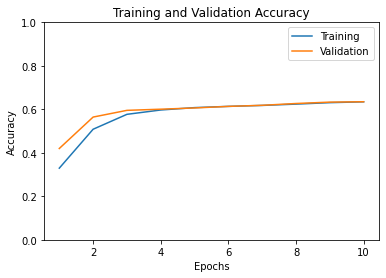

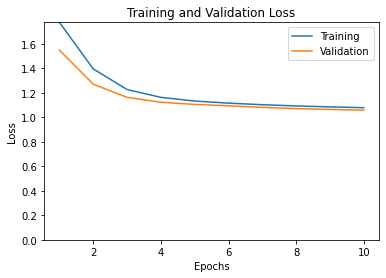

Confusion Matrix


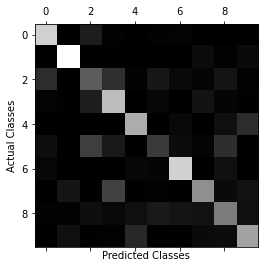

In [11]:
run_experiment(hidden_layer_units=2, x=x_train_norm)

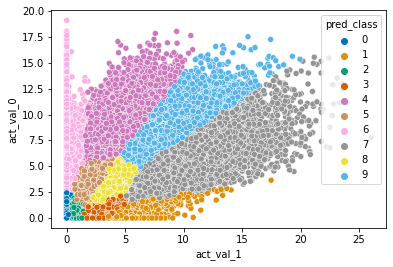

In [276]:
splot = sns.scatterplot(y='act_val_0', x='act_val_1', 
                     data=activation_df[['act_val_0','act_val_1','pred_class']],
                     hue='pred_class',
                     palette="colorblind")

# Results:
In experiment #2 a dense neural network consisting of 784 input nodes and one hidden layer with 2 nodes was trained. A maximum accuracy of 0.6634 was achieved after 10 epochs and the confusion matrix showed considerably less variability between predicted and expected values compare to experiment #1. There was minimal overlap between the ranges of values in the boxplot for experiment #2, comparable to that seen in experiment #1. 

The output of the two hidden nodes are plotted using a scatterplot with points color coded according to which of the 10 classes the the output of the two nodes predicts. Clear dilineation of predicted classes is noted in the plot.

# EXPERIMENT 3: 
You can explore with more hidden nodes. Then end up with 1 ‘final’ model. Say the ‘best’ model.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 500)               392500    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2230 - accuracy: 0.9334 - val_loss: 0.1277 - val_accuracy: 0.9647
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0954 - accuracy: 0.9718 - val_loss: 0.1115 - val_accuracy: 0.9699
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0666 - accuracy: 0.9811 - val_loss: 0.1085 - val_accuracy: 0.9721
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.

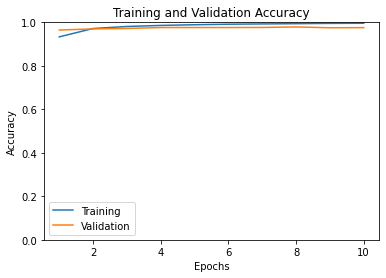

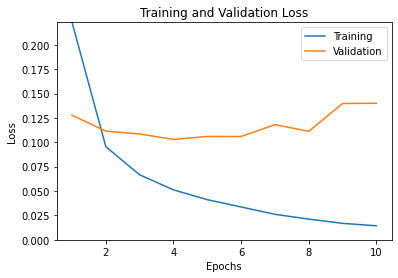

Confusion Matrix


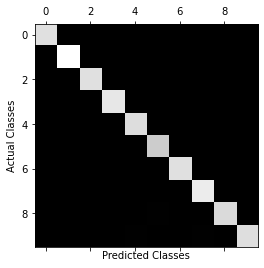

In [12]:
run_experiment(hidden_layer_units=500, x=x_train_norm) #rmsprop

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 500)               392500    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2250 - accuracy: 0.9328 - val_loss: 0.1163 - val_accuracy: 0.9653
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0903 - accuracy: 0.9724 - val_loss: 0.0990 - val_accuracy: 0.9700
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0575 - accuracy: 0.9817 - val_loss: 0.1048 - val_accuracy: 0.9688
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.

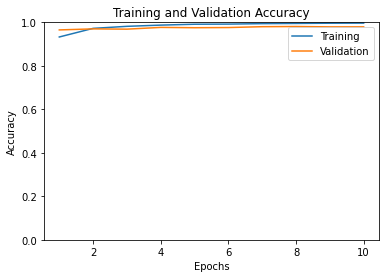

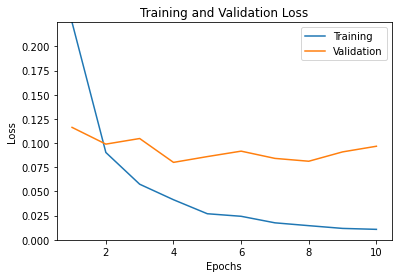

Confusion Matrix


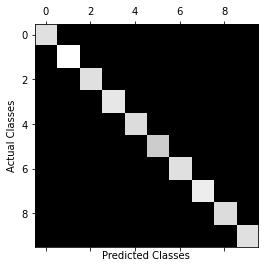

In [13]:
run_experiment(hidden_layer_units=500, x=x_train_norm, optimizer='adam')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 500)               392500    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6670 - accuracy: 0.8429 - val_loss: 0.3621 - val_accuracy: 0.9050
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3451 - accuracy: 0.9047 - val_loss: 0.2956 - val_accuracy: 0.9197
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2944 - accuracy: 0.9185 - val_loss: 0.2648 - val_accuracy: 0.9262
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.

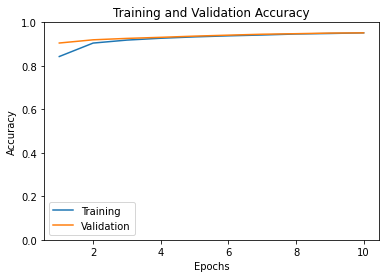

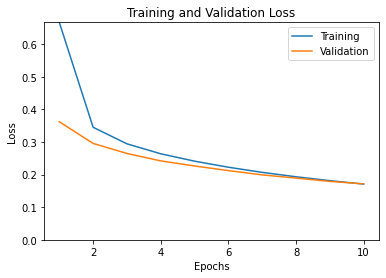

Confusion Matrix


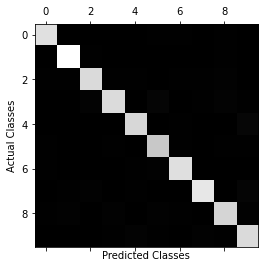

In [14]:
run_experiment(hidden_layer_units=500, x=x_train_norm, optimizer='SGD')

# Results:
In experiment #3 a dense neural network consisting of 784 input nodes and one hidden layer with 128 nodes was trained. A maximum accuracy of 0.9916 was achieved after 10 epochs and the confusion matrix visualization showed no perceptible difference between predicted and expected values compared to experiment #1. In the previous experiment, training and validation accuracy did not differ by much in fact at time validation accuracy was better. In Experiment number 3 it is clear that after 2 or 3 epochs there validation accuracy began to drop slightly below training accuracy. This gap between training and valdidation accuracy may be indiciative of overfitting and would likely widen with addition nodes to the hidden layer.  

# EXPERIMENT 4:
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

In [27]:
# from sklearn.decomposition import PCA

# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

n_components=154
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component '+str(x) for x in range(n_components)])
print(x_train_norm.shape)
print(principalComponents.shape)

(60000, 784)
(60000, 154)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 784)               121520    
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 129,370
Trainable params: 129,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2219 - accuracy: 0.9392 - val_loss: 0.1069 - val_accuracy: 0.9698
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.0944 - val_accuracy: 0.9721
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0401 - accuracy: 0.9884 - val_loss: 0.0887 - val_accuracy: 0.9749
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0

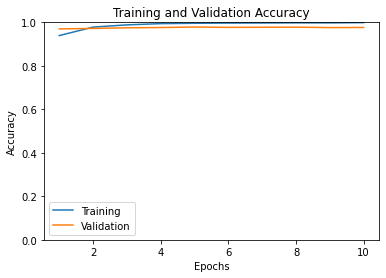

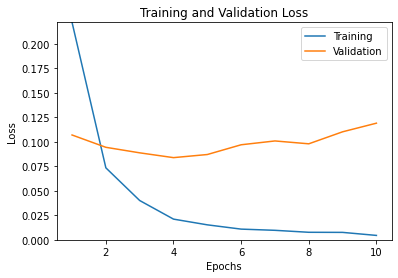

Confusion Matrix


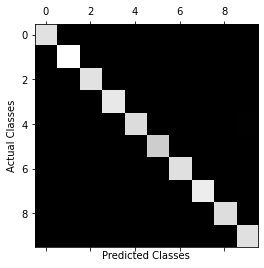

In [30]:
run_experiment(hidden_layer_units=784, x=principalComponents, optimizer='adam')

# Results
In experiment #4 PCA decomposition was used to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154. We retrained the model on these reduced feature using the same parameters as in Experiment 3, this time with 154 inputs nodes. Performance was slightly improved reaching 0.9999 after 10 epochs compared to 0.9965 in experiment #3. With PCA decomposition the number of dimensions was reduced to 154 without sacrificing performance or widening the gap between validation and training accuracy.

# EXPERIMENT 5:
We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

In [31]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

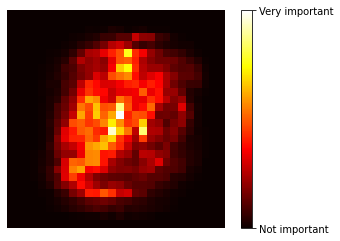

In [32]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [33]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

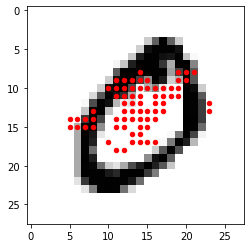

In [34]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [35]:
# Create training and test images using just the 70 pixel locations obtained above
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 784)               55664     
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 63,514
Trainable params: 63,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4765 - accuracy: 0.8566 - val_loss: 0.2980 - val_accuracy: 0.9106
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2787 - accuracy: 0.9159 - val_loss: 0.2525 - val_accuracy: 0.9227
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2248 - accuracy: 0.9301 - val_loss: 0.2148 - val_accuracy: 0.9345
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1

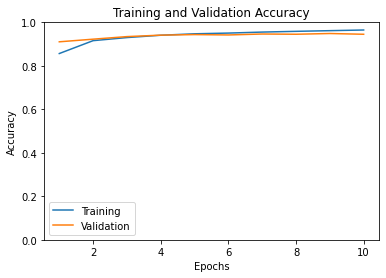

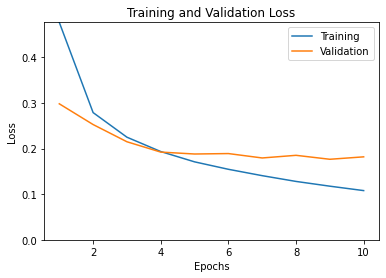

Confusion Matrix


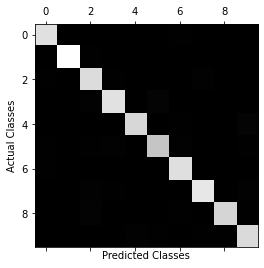

In [36]:
run_experiment(hidden_layer_units=784, x=train_images_sm, optimizer='adam')

# Results
In experiment #5 Random Forest classifier was used to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels), eliminatign all other features and trained the dense neural network using these 70 features and the same parameters as for experiments #3 adn #4. Performance was markedly worse reaching 0.9588 after 10 epochs compared to 0.9965 in experiment #3 and 0.9998 in experiment #4. In this case accuracy was affected for the sake of dimensionality reduction via feature elimination.

# EXPERIMENT 6:
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 2. The features are plotted using a scatterplot with points color coded according to which of the 10 classes wer predicted. The model was retrained on thee 2 PCA components using the same parameters as for experiments 3, 4, and 5.

In [46]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

n_components=2
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component '+str(x) for x in range(n_components)])
print(x_train_norm.shape)
print(principalComponents.shape)

(60000, 784)
(60000, 2)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 784)               2352      
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 10,202
Trainable params: 10,202
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3833 - accuracy: 0.4383 - val_loss: 1.3159 - val_accuracy: 0.4603
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3389 - accuracy: 0.4559 - val_loss: 1.3053 - val_accuracy: 0.4662
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3340 - accuracy: 0.4583 - val_loss: 1.3008 - val_accuracy: 0.4666
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3

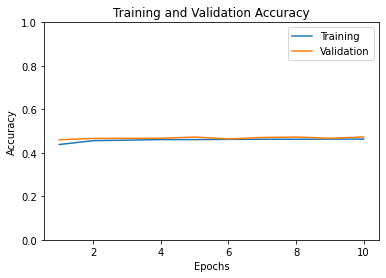

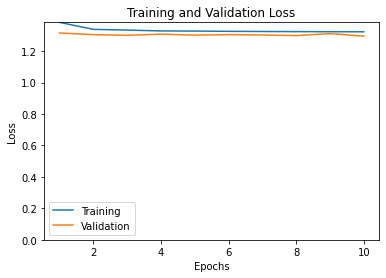

Confusion Matrix


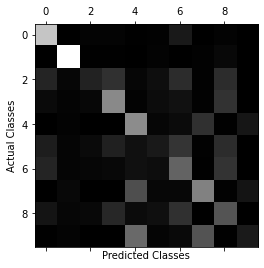

In [47]:
run_experiment(hidden_layer_units=784, x=principalComponents, optimizer='adam')

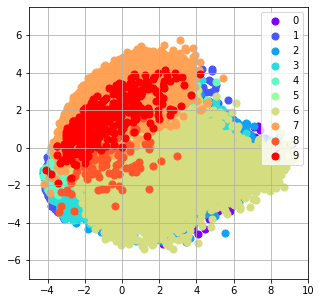

In [50]:
def pca_plot(targets = [0,1,2,3,4,5,6,7,8,9],colors = cm.rainbow(np.linspace(0, 1, 10))):
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 
    #ax.set_xlabel('Principal Component 1', fontsize = 15)
    #ax.set_ylabel('Principal Component 2', fontsize = 15)
    #ax.set_title('2 component PCA', fontsize = 20)
    ax.set_ylim(-7,7.5)
    ax.set_xlim(-5,10)
    #colors = ['r', 'g', 'b']
    from matplotlib import cm


    #colors = cm.rainbow(np.linspace(0, 1, 10))

    for target, color in zip(targets,colors):
        indicesToKeep = pixel_pca_df['pred_class'] == target
        ax.scatter(pixel_pca_df.loc[indicesToKeep, 'principal component 0']
                   , pixel_pca_df.loc[indicesToKeep, 'principal component 1']
                   , c = color.reshape(1,-1)
                   , s = 50
                  )
    ax.legend(targets)
    ax.grid()

pca_plot()

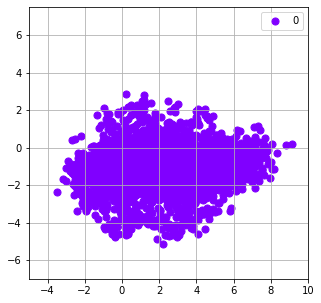

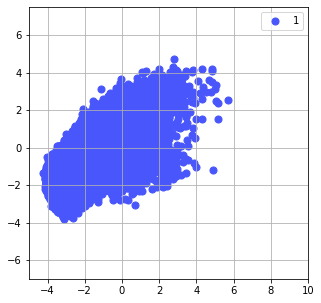

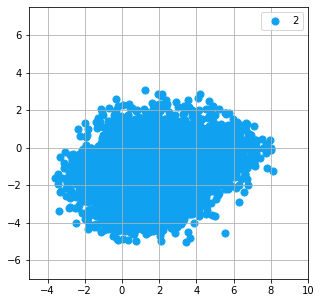

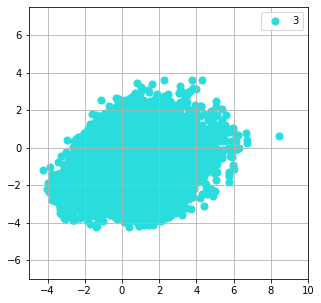

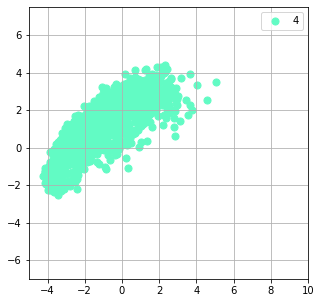

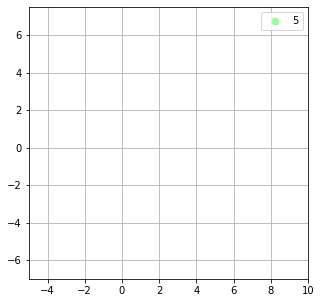

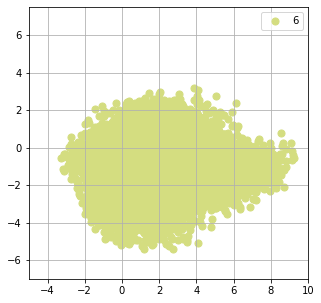

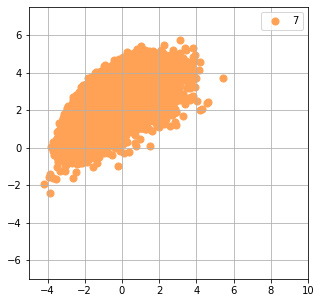

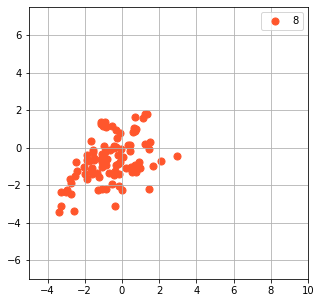

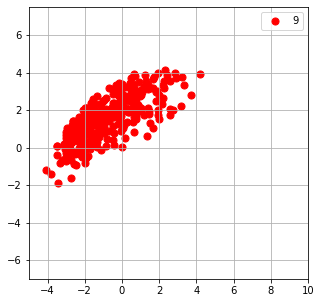

In [52]:
colors = cm.rainbow(np.linspace(0, 1, 10))
for i in [0,1,2,3,4,5,6,7,8,9]:
    pca_plot(targets=[i], colors = [colors[i]])

# Results
Principal Component Analysis (PCA) was used to reduce dimensionality to 2 components that could easily be visualized on a 2d plot. For the benefit of insight into the representation of data in the model, the accuracy was greatly reduced. After 10 epochs an accuracy of on 0.46 was achieved. A great deal of overlap was noted on the scatter lot of the 2 pca dimensions but clustering of predictions could be noted, it is clear that greater dimensionality achieved better performance.